Initial data sample:
   Year  Month Number Month     Utility       Owner            Units  \
0  2019             8   Aug  Passengers      Campus              PAX   
1  2019             8   Aug       Water      Tenant  Million Gallons   
2  2019             8   Aug       Water  Commission  Million Gallons   

          Usage  
0  5.750758e+06  
1  1.512082e+01  
2  2.767076e+01  

Prepared data for Electricity - Tenant:
                 Usage
Date                  
2013-01-01  14002156.0
2013-02-01  12631776.0
2013-03-01  13894596.0
2013-04-01  13548377.0
2013-05-01  13646478.0

Time range: 2013-01-01 00:00:00 to 2019-08-01 00:00:00
Number of data points: 80

Attempting standard decomposition...


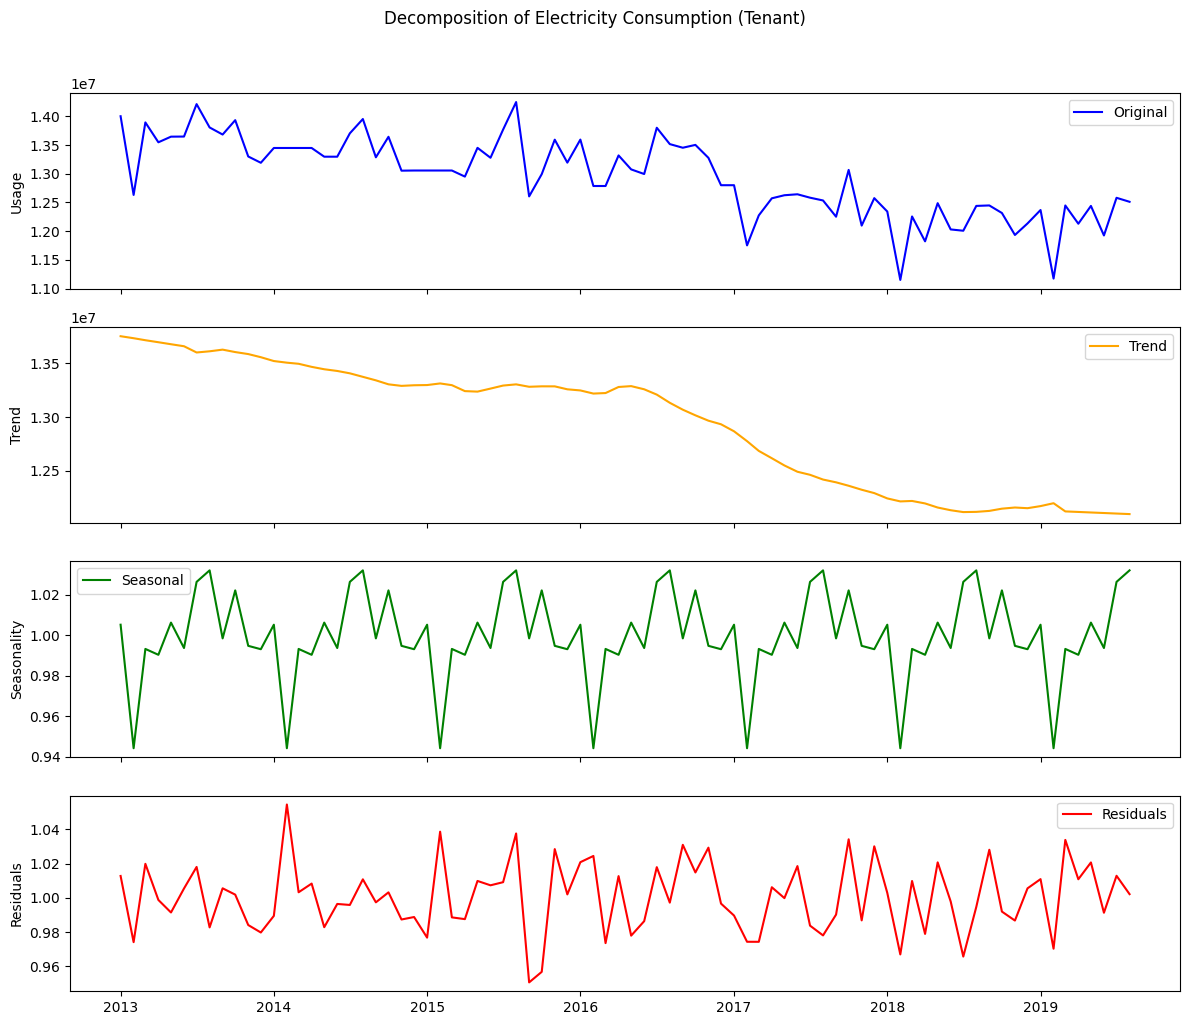


=== Analysis Results ===
1. Trend Analysis:
   - Shows long-term patterns in the data
   - Increasing trend suggests growing consumption
   - Decreasing trend suggests reduced usage or efficiency gains

2. Seasonality Analysis (12-month cycle):
   - Reveals repeating annual patterns
   - For electricity, look for summer/winter peaks

3. Residual Analysis:
   - Random residuals indicate good model fit
   - Patterns may suggest missing factors in the model


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import numpy as np

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Configuration ---
file_path = 'C:/Users/USER/Downloads/MEC.csv'
utility_type = 'Electricity'  # Options: 'Electricity', 'Water', 'Gas', 'Passengers'
owner_type = 'Tenant'         # Options: 'Tenant', 'Commission'
frequency = 12                # Monthly data with yearly seasonality

# --- Load and prepare data ---
try:
    # Read data in chunks if memory is an issue
    df = pd.read_csv(file_path)
    print("Initial data sample:")
    print(df.head(3))
    
    # Filter for selected utility and owner
    mask = (df['Utility'] == utility_type) & (df['Owner'] == owner_type)
    df = df[mask].copy()
    
    if df.empty:
        raise ValueError(f"No data found for {utility_type} - {owner_type}")
    
    # Create proper datetime index (using first day of each month)
    df['Date'] = pd.to_datetime(
        df['Year'].astype(str) + '-' + df['Month Number'].astype(str) + '-01'
    )
    df.set_index('Date', inplace=True)
    df = df[['Usage']].sort_index()
    
    # Convert to float32 to save memory if needed
    df['Usage'] = df['Usage'].astype(np.float32)
    
    print(f"\nPrepared data for {utility_type} - {owner_type}:")
    print(df.head())
    print(f"\nTime range: {df.index.min()} to {df.index.max()}")
    print(f"Number of data points: {len(df)}")

except Exception as e:
    print(f"Data preparation error: {e}")
    exit()

# --- Time Series Decomposition ---
try:
    # First try with smaller chunks if memory is an issue
    if len(df) > 100:  # If dataset is large
        print("\nLarge dataset detected, trying alternative decomposition method...")
        # Calculate rolling statistics as approximation
        df['Trend'] = df['Usage'].rolling(window=frequency, min_periods=1).mean()
        df['Detrended'] = df['Usage'] / df['Trend']
        seasonal = df.groupby(df.index.month)['Detrended'].mean()
        df['Seasonal'] = df.index.month.map(seasonal)
        df['Residual'] = df['Usage'] / (df['Trend'] * df['Seasonal'])
        
        # Create decomposition plots
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
        
        # Original data
        ax1.plot(df.index, df['Usage'], label='Original', color='blue')
        ax1.set_ylabel('Usage')
        ax1.legend()
        
        # Trend component
        ax2.plot(df.index, df['Trend'], label='Trend', color='orange')
        ax2.set_ylabel('Trend')
        ax2.legend()
        
        # Seasonal component
        ax3.plot(df.index, df['Seasonal'], label='Seasonal', color='green')
        ax3.set_ylabel('Seasonality')
        ax3.legend()
        
        # Residuals
        ax4.plot(df.index, df['Residual'], label='Residuals', color='red')
        ax4.set_ylabel('Residuals')
        ax4.legend()
        
        plt.suptitle(f'Approximate Decomposition of {utility_type} Consumption ({owner_type})', y=1.02)
        plt.tight_layout()
        plt.show()
        
        print("\nNOTE: Used approximate decomposition due to memory constraints")
    else:
        # Try standard decomposition with reduced memory usage
        print("\nAttempting standard decomposition...")
        decomposition = seasonal_decompose(
            df['Usage'],
            model='multiplicative',
            period=frequency,
            extrapolate_trend='freq'
        )
        
        # Create decomposition plots
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
        
        # Original data
        ax1.plot(df.index, df['Usage'], label='Original', color='blue')
        ax1.set_ylabel('Usage')
        ax1.legend()
        
        # Trend component
        ax2.plot(df.index, decomposition.trend, label='Trend', color='orange')
        ax2.set_ylabel('Trend')
        ax2.legend()
        
        # Seasonal component
        ax3.plot(df.index, decomposition.seasonal, label='Seasonal', color='green')
        ax3.set_ylabel('Seasonality')
        ax3.legend()
        
        # Residuals
        ax4.plot(df.index, decomposition.resid, label='Residuals', color='red')
        ax4.set_ylabel('Residuals')
        ax4.legend()
        
        plt.suptitle(f'Decomposition of {utility_type} Consumption ({owner_type})', y=1.02)
        plt.tight_layout()
        plt.show()
    
    # Analysis summary
    print("\n=== Analysis Results ===")
    print(f"1. Trend Analysis:")
    print("   - Shows long-term patterns in the data")
    print("   - Increasing trend suggests growing consumption")
    print("   - Decreasing trend suggests reduced usage or efficiency gains")
    
    print(f"\n2. Seasonality Analysis ({frequency}-month cycle):")
    print("   - Reveals repeating annual patterns")
    print("   - For electricity, look for summer/winter peaks")
    
    print("\n3. Residual Analysis:")
    print("   - Random residuals indicate good model fit")
    print("   - Patterns may suggest missing factors in the model")

except MemoryError:
    print("\nMemory error occurred during decomposition. Try:")
    print("- Reducing the dataset size")
    print("- Using a machine with more RAM")
    print("- Trying the additive model instead")
except Exception as e:
    print(f"\nDecomposition failed: {e}")
    print("Possible solutions:")
    print("- Try 'additive' instead of 'multiplicative' model")
    print("- Check for missing/irregular data points")
    print("- Reduce the seasonal period (frequency parameter)")